In [ ]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import nltk


In [ ]:
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/data.csv", filename="data.csv")
df = pd.read_csv("data.csv")
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2382


In [ ]:
data = pd.read_csv("data.csv", nrows =3000 ) # 56만개중에서 10만개 만 읽어옴
len(data)

2382

In [ ]:
import nltk
nltk.download('stopwords')

def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['cleaned'][:5]

0    know power shifting west east north south pres...
1    following success accidental billionaires mone...
2    tap power social software networks build busin...
3    william j bernstein american financial theoris...
4    amazing book joined steve jobs many akio morit...
Name: cleaned, dtype: object

In [ ]:
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2381


In [ ]:
df = df[['title','cleaned']]
df.head()

,title,cleaned
0,The End of Power: From Boardrooms to Battlefie...,know power shifting west east north south pres...
1,"Console Wars: Sega, Nintendo, and the Battle t...",following success accidental billionaires mone...
2,Trust Agents: Using the Web to Build Influence...,tap power social software networks build busin...
3,The Four Pillars of Investing,william j bernstein american financial theoris...
4,Made in Japan: Akio Morita and Sony,amazing book joined steve jobs many akio morit...


In [ ]:
df.sample(10)

,title,cleaned
180,Managing Transitions: Making the Most of Change,adrian j slywotzky born consultant author seve...
474,Strategy: A History,midas touch donald trump robert kiyosaki ask q...
262,Clockwork: Design Your Business to Run Itself,traits make sam zell one worlds successful ent...
241,A Man for All Markets,finally business book makers managers are read...
2271,Even Cowgirls Get the Blues,starring sissy hankshaw flawlessly beautiful a...
2015,The Likeness,compelling the boston globe pitch perfect ente...
2287,Vanishing Acts,delia hopkins led charmed life raised rural ne...
407,Het weekend van 7 dagen,true story behind rise tyrannical genius trans...
770,Why We Buy: The Science of Shopping,method madness comes shopping hailed san franc...
1626,Hard-Boiled Wonderland and the End of the World,a narrative particle accelerator zooms wild tu...


In [ ]:
print(df['cleaned'].nunique())
print(df['title'].nunique())

2360
2377


In [ ]:
# text 열에서 중복 제거
df.drop_duplicates(subset=['cleaned'], inplace=True)
len(df)

2360

In [ ]:
print(df.isnull().sum())

title      0
cleaned    0
dtype: int64


In [ ]:
df.dropna(axis=0, inplace=True)
len(df)

2360

In [ ]:
# 줄임말(축약어)
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
                "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"}

In [ ]:
# 불용어 다운로드
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# 불용어
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'again', 'y', "wouldn't", "shouldn't", "you've", 'couldn', 'mightn', 'yourself', 'shan', 'and', 'our', 'your', 've', 'who', 'was', "mightn't", "haven't", 'don', 'on', 'haven', 'own', 'or', 'then', 'out', "couldn't", 'any', 'isn', 'they', 'above', 'few', "don't", "weren't", "it's", 'themselves', 'shouldn', "you're", 'his', 'not', 'below', 'their', 'having', 'but', 'hadn', 'before', 'will', 'each', "that'll", 'more', 'for', 'whom', 'when', 'all', 'where', 'such', 'yourselves', "isn't", 'is', 'm', "doesn't", 'here', 'weren', 'him', 'hasn', 'being', 'which', 'an', 'just', 'you', 'than', 't', "you'll", 'itself', 's', 'them', 'her', 'by', 'had', 'a', 'i', 'as', 'into', 'theirs', 'himself', 'during', 'am', 'very', 'how', 'do', 'only', 're', "won't", 'mustn', 'against', "aren't", 'these', 'some', 'up', 'about', 'hers', 'has', 'at', 'there', 'once', 'can', 'doesn', "shan't", 'to', 'what', 'be', 'are', 'it', 'because', 'o', 'wasn', 'have', 'won', 'too', 'yours', 'she', 'herself', '

In [ ]:
# remove_stopwords = True 는 지우면 됨
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower()                     # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)   # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence)             # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence)         # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)   # m이 2개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [ ]:
temp_cleaned = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_title = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_cleaned))
print(preprocess_sentence(temp_title, 0))  # 불용어를 제거하지 않고 괄호로 닫힌 문자열을 제거한다

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [ ]:
clean_cleaned = []
for s in df['cleaned']:
    clean_cleaned.append(preprocess_sentence(s))
clean_cleaned[:5]

['know power shifting west east north south presidential palaces public squares formidable corporate behemoths nimble startups slowly surely men women power merely shifting dispersing also decaying power today constrained risk losing ever end power award winning columnist former foreign policy editor moiss nam illuminates struggle dominant megaplayers new micropowers challenging every field human endeavor drawing provocative original research nam shows antiestablishment drive micropowers topple tyrants dislodge monopolies open remarkable new opportunities also lead chaos paralysis nam deftly covers seismic changes underway business religion education within families matters war peace examples abound walks life eighty nine countries ruled autocrats today half world population lives democracies ceo constrained shorter tenures predecessors modern tools war cheaper accessible make possible groups like hezbollah afford drones second half top ten hedge funds earned world largest six banks co

In [ ]:
clean_title = []
for s in df['title']:
    clean_title.append(preprocess_sentence(s, 0))
clean_title[:5]

<ipython-input-98-a41c768713bd>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


['the end of power from boardrooms to battlefields and churches to states why being in charge is not what it used to be',
 'console wars sega nintendo and the battle that defined generation',
 'trust agents using the web to build influence improve reputation and earn trust',
 'the four pillars of investing',
 'made in japan akio morita and sony']

In [ ]:
df['cleaned'] = clean_cleaned
df['title'] = clean_title

In [ ]:
df.replace('', np.nan, inplace=True)
print(df.isnull().sum())

title      4
cleaned    0
dtype: int64


In [ ]:
df.dropna(axis = 0, inplace = True)
len(df)

2356

Text min : 4
Text max : 729
Text mean : 106.30050933786077
title min : 1
title max : 26
title mean : 6.540747028862479


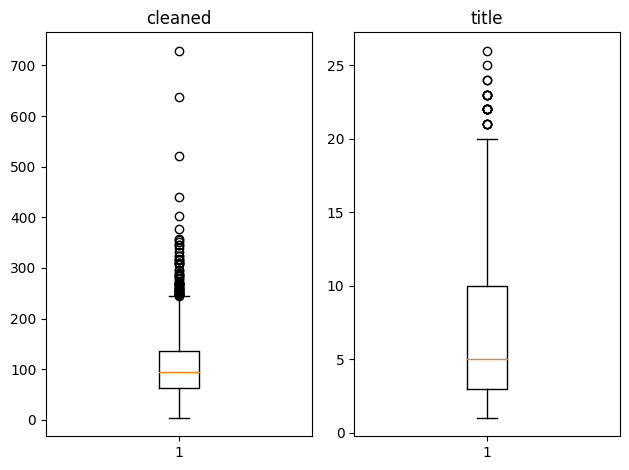

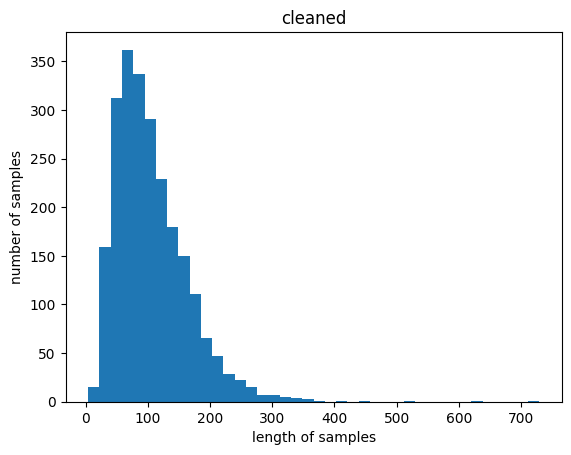

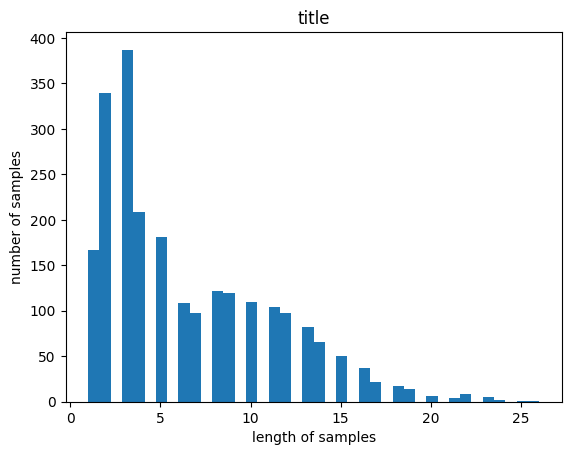

In [ ]:
# 길이 분포 시각화
cleaned_len = [len(s.split()) for s in df['cleaned']]
title_len = [len(s.split()) for s in df['title']]

print('Text min : {}'.format(np.min(cleaned_len)))
print('Text max : {}'.format(np.max(cleaned_len)))
print('Text mean : {}'.format(np.mean(cleaned_len)))
print('title min : {}'.format(np.min(title_len)))
print('title max : {}'.format(np.max(title_len)))
print('title mean : {}'.format(np.mean(title_len)))

plt.subplot(1,2,1)
plt.boxplot(cleaned_len)
plt.title('cleaned')
plt.subplot(1,2,2)
plt.boxplot(title_len)
plt.title('title')
plt.tight_layout()
plt.show()

plt.title('cleaned')
plt.hist(cleaned_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('title')
plt.hist(title_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.show()

In [ ]:
cleaned_max_len = 50
title_max_len = 8

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [ ]:
below_threshold_len(cleaned_max_len, df['cleaned'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.15492359932088284


In [ ]:
below_threshold_len(title_max_len, df['title'])

전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.6833616298811545


In [ ]:
# 최대 길이보다 큰 샘플들은 제거
df = df[df['cleaned'].apply(lambda x: len(x.split()) <= cleaned_max_len)]       # Text의 길이가 50이하인 행 추출
df = df[df['title'].apply(lambda x: len(x.split()) <= title_max_len)] # Summary의 길이가 8이하인 행 추출
print('전체 샘플수 :',(len(df)))

전체 샘플수 : 295


In [ ]:
df.head()

,title,cleaned
3,the four pillars of investing,william bernstein american financial theorist ...
4,made in japan akio morita and sony,amazing book joined steve jobs many akio morit...
11,the road ahead,harvard dropout founded microsoft based vision...
12,principles of marketing,professor kotler book marketing management wor...
20,the one minute manager meets the monkey,ken blanchard one influential leadership exper...


In [ ]:
# 시작 토큰과 종료 토큰을 추가
df['title'] = df['title'].apply(lambda x : 'sostoken '+ x + ' eostoken')
data.head()

,Unnamed: 0.1,Desc,Unnamed: 0,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [ ]:
cleaned_df = list(df['cleaned'])
title_df = list(df['title'])

In [ ]:
# 훈련 데이터와 테스트 데이터를 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_df, title_df, test_size=0.2, random_state=0, shuffle=True)

print('X_train :', len(X_train))
print('y_train :',len(y_train))
print('X_test :',len(X_test))
print('y_test :',len(y_test))

X_train : 236
y_train : 236
X_test : 59
y_test : 59


In [ ]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0                              # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                            # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                             # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로
for key, value in src_tokenizer.word_counts.items():  # word_counts :단어의 빈도
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('--X_train--')
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

--X_train--
단어 집합(vocabulary)의 크기 : 4423
등장 빈도가 6번 이하인 희귀 단어의 수: 4221
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 202
단어 집합에서 희귀 단어의 비율: 95.43296405154872
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 71.27749576988155


In [ ]:
# Text 토큰화
src_vocab = 3000
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(X_train)

X_train = src_tokenizer.texts_to_sequences(X_train)
X_test = src_tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:5])

[[364, 274, 1548, 1549, 203, 274, 522, 364, 1550, 826, 4, 1551, 275, 365, 1552, 364, 274, 91, 1553, 523, 524, 276, 274, 827, 1554, 1555, 828, 30, 92, 1556, 364, 274, 1557, 829, 1558, 1559, 829, 1560, 1561, 1562, 1563, 525, 366, 109, 1564, 830, 110, 58, 526, 3], [831, 1565, 832, 50, 6, 93, 1566, 1567, 1568, 1569, 1570, 833, 1571, 527, 834, 111, 4, 835, 277, 112, 367, 113, 133, 11, 134, 832, 1572, 368, 1573, 836, 6, 369, 1574, 1575, 1576, 370, 1577, 528, 1578, 1579, 1580, 833], [278, 1581, 1582, 11, 80, 67, 29, 31, 93, 135, 1583, 67, 29, 136, 1, 529, 204, 530, 205, 837, 67, 29, 34, 114, 1584, 67, 1585, 1586, 1587, 838, 531, 1588, 133, 1589, 9, 1590, 31, 839], [371, 840, 13, 532, 372, 840, 115, 94, 1591, 373, 841, 137, 1592, 533, 533, 1593, 1594, 1595, 38, 372, 115, 138, 95, 68, 374, 206, 1596, 2, 842, 59, 1597, 375, 81, 843, 1598, 69, 534, 844, 17, 207, 279, 372, 95, 1599, 60, 376, 1600, 13, 1601], [9, 845, 535, 1602, 536, 537, 280, 167, 377, 1603, 538, 536, 378, 535, 208, 209, 536, 539,

In [ ]:
#  요약 데이터 토큰화
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(y_train)

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index)   # 단어의 수
rare_cnt = 0                                # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                              # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                               # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
print('--y_train--')
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


--y_train--
단어 집합(vocabulary)의 크기 : 514
등장 빈도가 5번 이하인 희귀 단어의 수: 506
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8
단어 집합에서 희귀 단어의 비율: 98.44357976653697
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 46.99162223914699


In [ ]:
tar_vocab = 500  # or 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(y_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
y_train = tar_tokenizer.texts_to_sequences(y_train)
y_test = tar_tokenizer.texts_to_sequences(y_test)

In [ ]:
# 빈 샘플 제거¶
drop_train = [index for index, sentence in enumerate(y_train) if len(sentence) == 2]
drop_test = [index for index, sentence in enumerate(y_test) if len(sentence) == 2]

In [ ]:
print('X_train :', len(X_train))
print('y_train :',len(y_train))
print('X_test :',len(X_test))
print('y_test :',len(y_test))

X_train : 236
y_train : 236
X_test : 59
y_test : 59


In [ ]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

print('X_train :', len(X_train))
print('y_train :',len(y_train))
print('X_test :',len(X_test))
print('y_test :',len(y_test))
X_test.shape

X_train : 232
y_train : 232
X_test : 47
y_test : 47


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


(47,)

In [ ]:
X_train = pad_sequences(X_train, maxlen = cleaned_max_len, padding='post')
X_test = pad_sequences(X_test, maxlen = cleaned_max_len, padding='post')
y_train = pad_sequences(y_train, maxlen = title_max_len, padding='post')
y_test = pad_sequences(y_test, maxlen = title_max_len, padding='post')


In [ ]:
X_train[:3]

array([[ 364,  274, 1548, 1549,  203,  274,  522,  364, 1550,  826,    4,
        1551,  275,  365, 1552,  364,  274,   91, 1553,  523,  524,  276,
         274,  827, 1554, 1555,  828,   30,   92, 1556,  364,  274, 1557,
         829, 1558, 1559,  829, 1560, 1561, 1562, 1563,  525,  366,  109,
        1564,  830,  110,   58,  526,    3],
       [ 831, 1565,  832,   50,    6,   93, 1566, 1567, 1568, 1569, 1570,
         833, 1571,  527,  834,  111,    4,  835,  277,  112,  367,  113,
         133,   11,  134,  832, 1572,  368, 1573,  836,    6,  369, 1574,
        1575, 1576,  370, 1577,  528, 1578, 1579, 1580,  833,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 278, 1581, 1582,   11,   80,   67,   29,   31,   93,  135, 1583,
          67,   29,  136,    1,  529,  204,  530,  205,  837,   67,   29,
          34,  114, 1584,   67, 1585, 1586, 1587,  838,  531, 1588,  133,
        1589,    9, 1590,   31,  839,    0,    0,    0,    0,    0,    0,
           0,    0,   

In [ ]:
X_test[:3]

array([[ 589,    2, 1833,   18,    4,  188,  113,  745, 2102,  630, 1409,
         116,  193, 2656,  646, 1158,  262,  343,  159, 1113,   26,  943,
        2454,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 188,  331,  782, 1438,   16, 1406,    9,  246,   24,  987,  768,
         733,    8,  190, 1786,  106,  477, 2339,  117,  116,  889, 1829,
         475,  992,   66,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [1289,   19,  589,  335,  648,  279, 1494, 1400,  213,  168,  187,
        2527, 2450,  260, 1426, 1481,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   

In [ ]:
y_test[:3]

array([[  1,  16, 121,   2,   0,   0,   0,   0],
       [  1,   5,   2,   0,   0,   0,   0,   0],
       [  1,  70,   6, 130,   2,   0,   0,   0]], dtype=int32)

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
embedding_dim = 64
hidden_size = 128

# 인코더
encoder_inputs = Input(shape=(cleaned_max_len,))  # text_max_len :50

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.0)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.0)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.0)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [ ]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.0)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 50, 64)               192000    ['input_6[0][0]']             
                                                                                                  
 lstm_4 (LSTM)               [(None, 50, 128),            98816     ['embedding_2[0][0]']         
                              (None, 128),                                                        
                              (None, 128)]                                                        
                                                                                            

In [ ]:
# 깃허브에 공개된 attention.py 사용하기
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [ ]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 50, 64)               192000    ['input_6[0][0]']             
                                                                                                  
 lstm_4 (LSTM)               [(None, 50, 128),            98816     ['embedding_2[0][0]']         
                              (None, 128),                                                        
                              (None, 128)]                                                        
                                                                                            

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)

# 약 9분 소요(GPU)
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:] \
                  ,epochs=5, callbacks=[es], batch_size = 256, validation_data=([X_test, y_test[:,:-1]], \
                  y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/5
1/1 [==============================] - 9s 9s/step - loss: 6.2162 - val_loss: 6.1753
Epoch 2/5
1/1 [==============================] - 1s 770ms/step - loss: 6.1891 - val_loss: 6.1301
Epoch 3/5
1/1 [==============================] - 1s 776ms/step - loss: 6.1598 - val_loss: 6.0417
Epoch 4/5
1/1 [==============================] - 1s 776ms/step - loss: 6.1026 - val_loss: 5.7262
Epoch 5/5
1/1 [==============================] - 1s 780ms/step - loss: 5.8992 - val_loss: 4.6071


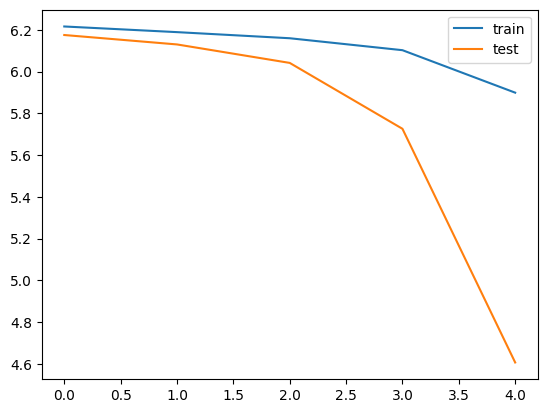

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])
encoder_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 64)            192000    
                                                                 
 lstm_4 (LSTM)               [(None, 50, 128),         98816     
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 lstm_5 (LSTM)               [(None, 50, 128),         131584    
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 lstm_6 (LSTM)               [(None, 50, 128),         1315

In [ ]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(cleaned_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

decoder_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, None, 64)             32000     ['input_7[0][0]']             
                                                                                                  
 input_8 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 128)]                0         []                            
                                                                                            

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(cleaned_df)
tfidf_matrix.shape

(295, 5067)

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print('코사인 유사도 연산 결과 :',cosine_sim.shape)

코사인 유사도 연산 결과 : (295, 295)


In [ ]:
title_to_index = dict(zip(df['title'], df.index))

idx = title_to_index['The Four Pillars of Investing']
print(idx)

3


In [ ]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = title_to_index[title]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:11]

    book_indices = [idx[0] for idx in sim_scores]

    return df['title'].iloc[book_indices]


In [ ]:
get_recommendations('The Four Pillars of Investing')

20              The One Minute Manager Meets the Monkey
8                Act Like a Leader, Think Like a Leader
13    Blockchain Revolution: How the Technology Behi...
48    Getting to Plan B: Breaking Through to a Bette...
37    The Leader Who Had No Title: A Modern Fable on...
47    The New Digital Age: Reshaping the Future of P...
28    Leadership and the One Minute Manager: Increas...
49    Youtility: Why Smart Marketing Is about Help N...
56    Thou Shall Prosper: Ten Commandments for Makin...
46    How Music Got Free: The End of an Industry, th...
Name: title, dtype: object

In [ ]:
def recommendations(title):
    books = df[['title', 'image_link']]

    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()
    idx = indices[title]

    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['title'])

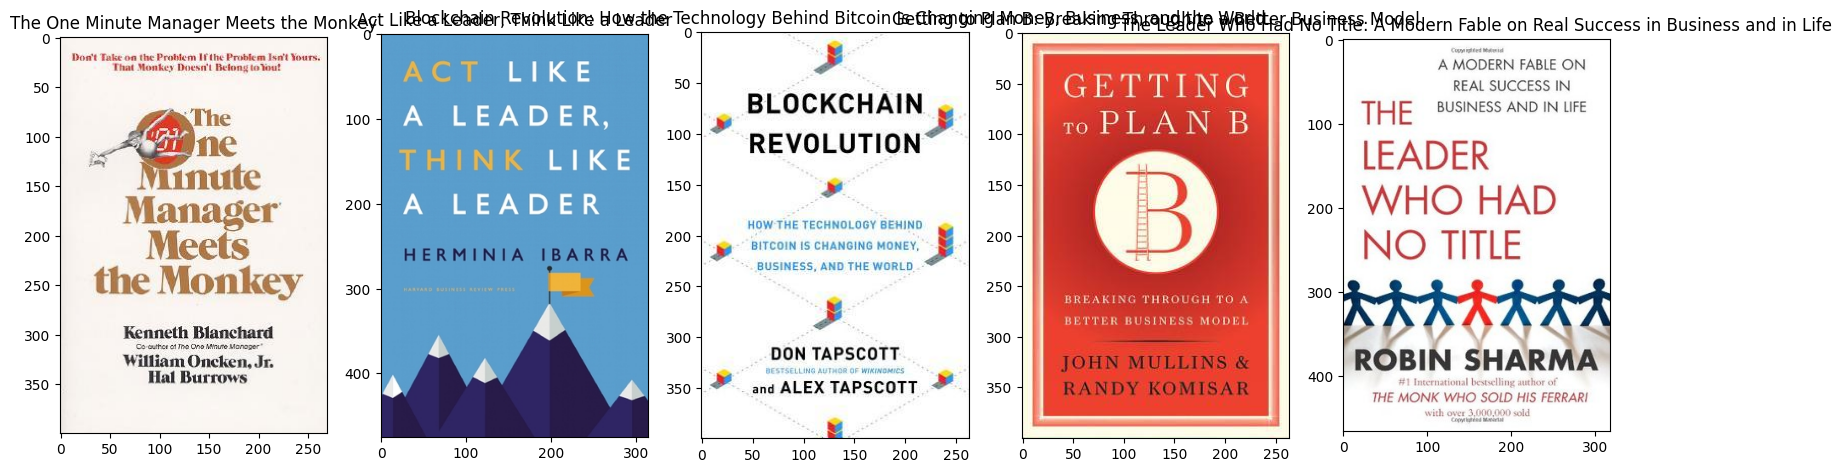

In [ ]:
recommendations("The Four Pillars of Investing")